# SikinCancer medical diagnosis with transfer learning


*   author: Jafet Israel Sierra Lagos
*   contact: jafet.sierra.l@gmail.com




In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jul  3 18:21:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#First conect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip '/content/drive/MyDrive/Proyectos/SkinCancer/data.zip'

In [4]:
#Importamos todas las librerias y paquetes necesarios
import os
import csv
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, InputLayer, Flatten, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import L2
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

## Ordenamiento de datos y creacion de subcarpetas por cada clase

In [ ]:
#Meta data and file index with images ids and diagnosis 
#Archivo con los id's de cada imagen y el diagnostico 
df = pd.read_csv('/content/drive/MyDrive/Proyectos/SkinCancer/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### image path

In [ ]:
#Prueba para saber si el ordenamiento en clases resulto bien
df.loc[df['image_id']=='ISIC_0024312']

,lesion_id,image_id,dx,dx_type,age,sex,localization
700,HAM_0001359,ISIC_0024312,bkl,histo,75.0,male,lower extremity


## **The types of diagnosis can be seen below:  \Los tipos de diagnostico se pueden ver abajo**

*   0: akiec,
*   1: bcc,
*   2: bkl, 
*   3: dermatofibroma (df),
*   4: melanoma (mel),
*   5: melanocytic nevi (nv),
*   6: vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)


In [ ]:
img_list = list(df['image_id'])
len(img_list)

10015

In [ ]:
df['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [ ]:
df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

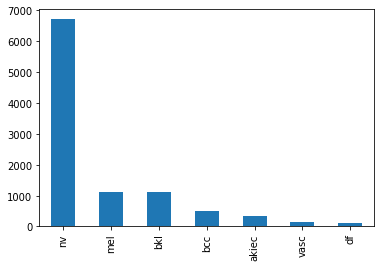

In [ ]:
df['dx'].value_counts().plot(kind='bar')

Besides that, in this case i'll separate my data into two classes. Melanoma and non_melanoma

I used split-folders to create a train validation test split with stratified sampling from the original dataset

## Preprocessing data

In [16]:
def get_ImageDataGenerator():
  return ImageDataGenerator(
      #preprocessing_function=preprocess_input,
      brightness_range=(0.3,1),
      zoom_range=0.2,
  )

def get_generator(image_data_generator,directory,batch_s=None,seed=None,shuffle=None):
  return image_data_generator.flow_from_directory(
      directory,
      target_size=(224,224),
      batch_size=batch_s,
      class_mode='categorical',
      shuffle=shuffle,
      seed=seed
  )

In [17]:
my_directory = '/content/data'
batch = 32
image_gen = get_ImageDataGenerator()
train_generator = get_generator(image_gen,my_directory+'/train',batch,1,True)
val_generator   = get_generator(image_gen,my_directory+'/val',batch,1,False)
test_generator  = get_generator(image_gen,my_directory+'/test',1,1,False)

Found 14242 images belonging to 2 classes.
Found 1780 images belonging to 2 classes.
Found 1782 images belonging to 2 classes.


In [18]:
batch_prueba = next(train_generator)

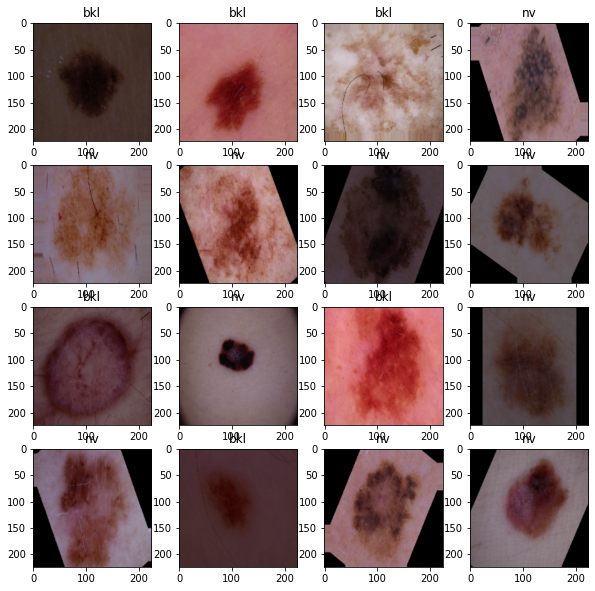

In [20]:
#Now that i have a data generator, i'll print out some samples
classes = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']

plt.figure(figsize=(10,10))
for n in range(16):
  ax = plt.subplot(4,4,n+1)
  plt.imshow(batch_prueba[0][n].astype('uint8'))
  plt.title(classes[np.where(batch_prueba[1][n]==1.)[0][0]])
  #plt.axis('off')

In [21]:
from tensorflow.python.keras.layers.pooling import AveragePooling2D

#Pretained Model
def load_pretrained_model():
  input_t   = Input(shape=(224,224,3))
  x         = tf.cast(input_t, tf.float32)
  x         = preprocess_input(x)
  #model = MobileNetV2(weights='imagenet',include_top=False,input_shape=input_t)
  #model = ResNet50V2(weights='imagenet',include_top=False,input_tensor=input_t)
  model = VGG19(weights='imagenet',input_tensor=x,include_top=False)
  #Hacemos un freezing a las capas que ya estaban entrenadas en el modelo cargado
  model.trainable = False
  return model

#añadimos nuestro nuevo modelo encima del preentrenado y compilamos
def add_new_head(feature_extractor_model):
  prev_output   = feature_extractor_model.output
  head_conv2d   = Conv2D(20,2)(prev_output)
  head_batchN1  = BatchNormalization()(head_conv2d)
  head_relu_1   = Activation('relu')(head_batchN1)
  head_maxpool  = MaxPooling2D()(head_relu_1)
  head_flatten  = Flatten()(head_maxpool)
  head_dense1   = Dense(512, kernel_regularizer=L2(1e-5),kernel_initializer='he_normal',bias_initializer='zeros')(head_flatten)
  head_batchN2  = BatchNormalization()(head_dense1)
  head_relu_2   = Activation('relu')(head_batchN2)
  head_drop1    = Dropout(0.5)(head_relu_2)
  head_output   = Dense(2,activation='softmax')(head_drop1)
  model         = Model(inputs=feature_extractor_model.input,outputs=head_output)

  opt = Adam(1e-3)
  metric = [
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
  ]
  model.compile(
      optimizer=opt,
      loss='categorical_crossentropy',
      metrics=metric
  )
  return model

In [22]:
base_model = load_pretrained_model()
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928 

In [23]:
#new_model = add_new_head(feature_stractor)
new_model = add_new_head(base_model)
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      3692

In [24]:
len(new_model.layers)

35

In [25]:
def scheduler(epoch,lr):
  if epoch<1:
    return lr
  else:
    return lr*tf.math.exp(-0.105)

def checkpoint_best():
  path = 'checkpoint_best/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_categorical_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp

def train_model_gen(model,train_gen,val_gen,epochs):
  early_stop = EarlyStopping(patience=1,monitor='val_categorical_accuracy')
  #reduce_lr  = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=2)

  return model.fit(
      train_gen,
      steps_per_epoch  = train_gen.samples // batch,
      validation_data  = val_gen,
      validation_steps = val_gen.samples // batch,
      epochs=epochs,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler),early_stop,checkpoint_best()],
      verbose=1
      )

## Entrenamiento

In [26]:
history = train_model_gen(new_model,train_generator,val_generator,2)

Epoch 1/2
445/445 [==============================] - ETA: 0s - loss: 0.3541 - categorical_accuracy: 0.8407 - precision_1: 0.8407 - recall_1: 0.8407
Epoch 1: val_categorical_accuracy improved from -inf to 0.87614, saving model to checkpoint_best/checkpoint
445/445 [==============================] - 316s 675ms/step - loss: 0.3541 - categorical_accuracy: 0.8407 - precision_1: 0.8407 - recall_1: 0.8407 - val_loss: 0.2623 - val_categorical_accuracy: 0.8761 - val_precision_1: 0.8761 - val_recall_1: 0.8761 - lr: 0.0010
Epoch 2/2
445/445 [==============================] - ETA: 0s - loss: 0.2827 - categorical_accuracy: 0.8683 - precision_1: 0.8683 - recall_1: 0.8683
Epoch 2: val_categorical_accuracy improved from 0.87614 to 0.88409, saving model to checkpoint_best/checkpoint
445/445 [==============================] - 281s 631ms/step - loss: 0.2827 - categorical_accuracy: 0.8683 - precision_1: 0.8683 - recall_1: 0.8683 - val_loss: 0.2440 - val_categorical_accuracy: 0.8841 - val_precision_1: 0.88

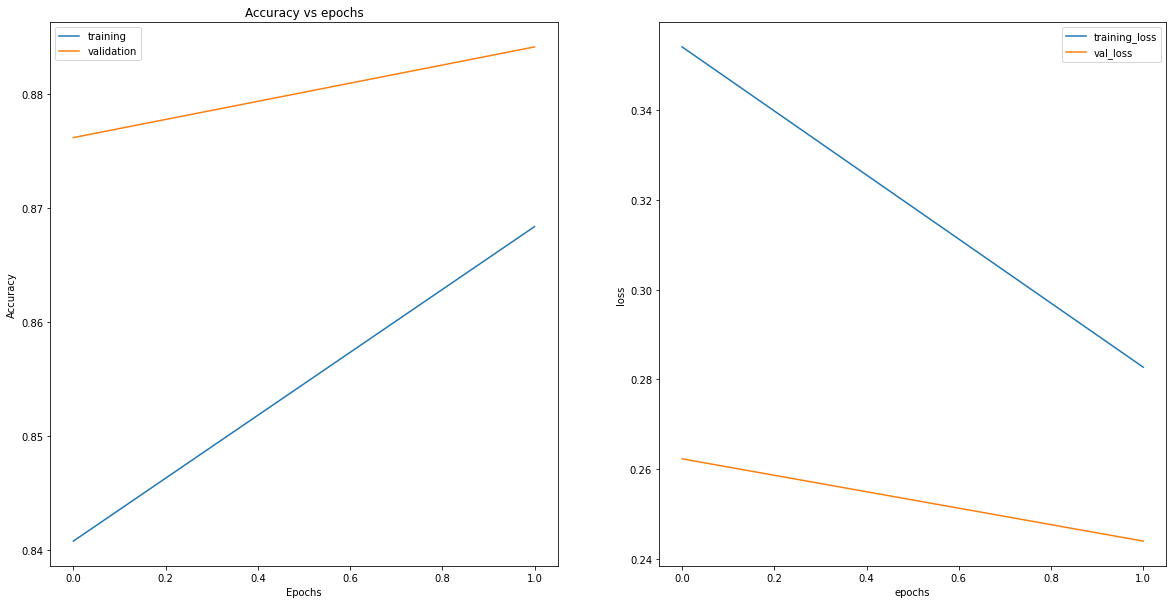

In [27]:
plt.figure(figsize=(20,10))
plt.subplot(121)
try:
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
except KeyError:
  plt.plot(history.history['acc_categorical_'])
  plt.plot(history.history['val_categorical_acc'])
plt.title('Accuracy vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training_loss','val_loss'])
plt.show()

## Final training pre-fine_tuning

## Fine Tunning section

In [28]:
print("Number of layers: ", len(base_model.layers))

Number of layers:  25


In [29]:
base_model.trainable =True
fine_tune_at = 23
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [30]:
early_stop = EarlyStopping(patience=1,monitor='val_categorical_accuracy')
fine_metric = [
            tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall()
  ]
new_model.compile(
    loss='categorical_crossentropy',
    metrics=fine_metric,
    optimizer = Adam(1e-5)
)
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      3692

In [31]:
ini_epochs = len(history.epoch)
fine_tun_epochs = 15
total_epochs = ini_epochs + fine_tun_epochs

def checkpoint_best_ft():
  path = 'checkpoint_best_ft/checkpoint'
  checkp = ModelCheckpoint(
      filepath=path,
      save_weights_only=True,
      save_freq='epoch',
      monitor='val_categorical_accuracy',
      save_best_only=True,
      verbose=1
  )
  return checkp
def train_model_fine_tuning(model,train_gen,val_gen,total_epochs,ini_epoch):
  early_stop = EarlyStopping(patience=1,monitor='val_categorical_accuracy')
  #reduce_lr  = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=2)
  return model.fit(
      train_gen,
      steps_per_epoch  = train_gen.samples // batch,
      validation_data  = val_gen,
      validation_steps = val_gen.samples // batch,
      epochs=total_epochs,
      initial_epoch=ini_epoch,
      callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler),early_stop,checkpoint_best_ft()],
      verbose=1
      )

In [32]:
fine_history = train_model_fine_tuning(new_model,train_generator,val_generator,total_epochs,ini_epochs)

Epoch 3/17
445/445 [==============================] - ETA: 0s - loss: 0.2567 - categorical_accuracy: 0.8804 - precision_2: 0.8804 - recall_2: 0.8804
Epoch 3: val_categorical_accuracy improved from -inf to 0.89830, saving model to checkpoint_best_ft/checkpoint
445/445 [==============================] - 279s 625ms/step - loss: 0.2567 - categorical_accuracy: 0.8804 - precision_2: 0.8804 - recall_2: 0.8804 - val_loss: 0.2299 - val_categorical_accuracy: 0.8983 - val_precision_2: 0.8983 - val_recall_2: 0.8983 - lr: 9.0032e-06
Epoch 4/17
445/445 [==============================] - ETA: 0s - loss: 0.2438 - categorical_accuracy: 0.8909 - precision_2: 0.8909 - recall_2: 0.8909
Epoch 4: val_categorical_accuracy did not improve from 0.89830
445/445 [==============================] - 276s 619ms/step - loss: 0.2438 - categorical_accuracy: 0.8909 - precision_2: 0.8909 - recall_2: 0.8909 - val_loss: 0.2317 - val_categorical_accuracy: 0.8983 - val_precision_2: 0.8983 - val_recall_2: 0.8983 - lr: 8.1058e

In [33]:
cat_acc     = [*history.history['categorical_accuracy'],*fine_history.history['categorical_accuracy']]
val_cat_acc = [*history.history['val_categorical_accuracy'],*fine_history.history['val_categorical_accuracy']]
loss_       = [*history.history['loss'],*fine_history.history['loss']]
val_loss    = [*history.history['val_loss'],*fine_history.history['val_loss']]

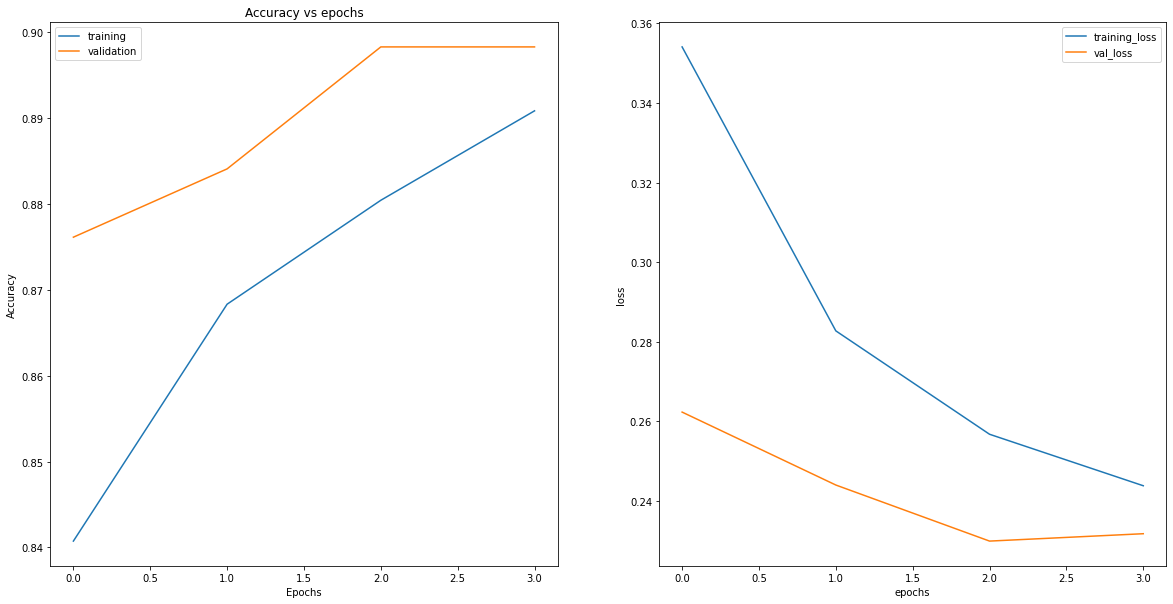

In [34]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(cat_acc)
plt.plot(val_cat_acc)
plt.title('Accuracy vs epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'])
plt.subplot(122)
plt.plot(loss_)
plt.plot(val_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training_loss','val_loss'])
plt.show()

## Model Evaluation on Test set

In [ ]:
## loading best weights 
new_model.load_weights('/content/checkpoint_best_ft/checkpoint')

In [35]:
version = '002'
tf.saved_model.save(new_model,f'/content/drive/MyDrive/Proyectos/SkinCancer/model_v_{version}')
#charged_model = load_model('/content/drive/MyDrive/Proyectos/SkinCancer/SkinCancer_model_v5.h5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/SkinCancer/model_v_002/assets


In [36]:
files = len(test_generator.filenames)

labels = []
for i in range(files):
  labels.append(test_generator.next()[1])

predictions = new_model.predict(test_generator,steps=files)
y_pred      = [np.argmax(x) for x in predictions]
y_true      = [np.argmax(y) for y in labels]

In [37]:
f1_score(y_true,y_pred)

0.8737522019964767

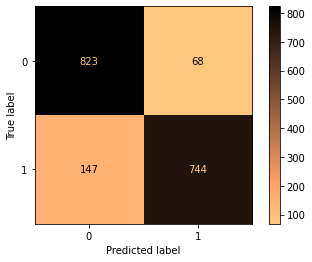

In [38]:
cm   = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='copper_r')
plt.show()

In [ ]:
new_model.save('/content/drive/MyDrive/Proyectos/SkinCancer/SkinCancer_model_v5.h5')

#model.load_weights('/content/drive/MyDrive/Introduction_tensorflow_week_5_assignment/checkpoint_best/checkpoint')
#get_test_accuracy(model, test_data_gray, test_targets)

### predict for a single image and printing the filters for some layers

In [39]:
import keras.backend as K
from keras.preprocessing.image import img_to_array

In [40]:
def load_img(path):
  img = tf.keras.utils.load_img(path,target_size=(224,224,3))
  img = img_to_array(img)
  img = np.expand_dims(img,0)
  #img = preprocess_input(img)
  #plt.imshow(img[0])
  return img
def predict_one(tensor):
  prediction = new_model.predict(tensor)
  return prediction


In [42]:
sample = load_img('/content/ISIC_0024306.jpg')
new_model.predict(sample)

array([[0.9956306 , 0.00436937]], dtype=float32)

In [44]:
func = K.function([new_model.layers[0].input],new_model.get_layer('block1_conv2').output)
final_conv_output = func(sample)
final_conv_output.shape

(1, 224, 224, 64)

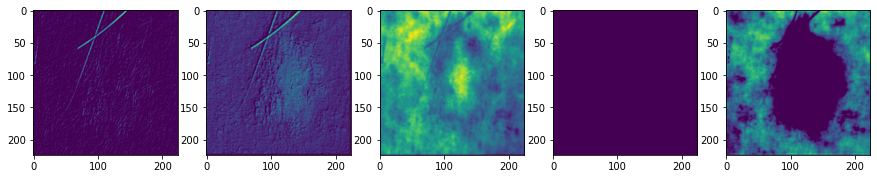

In [45]:
fig,ax = plt.subplots(1,5,figsize=(15,15))
j = 0
for i in range(final_conv_output.shape[-1]):
  if j<5:
    ax[i].imshow(final_conv_output[0,:,:,i])
  else:
    break
  j+=1
plt.show()

### Aditional functions and code employed


In [ ]:
#this part is only for the procces of re-ordering the data in a local pc, dont run here

#Este fue el proceeso que hice para re-organizar todo el contenido en subcarpetas con cada clase, no ejecutar aqui
#pues las rutas no son iguales y dará un error.
#This part is just for grouping and dividing all the data into separate folders, one for each class
#Adding ".jpg" to all element in the column "image_id" 
df = pd.read_csv('HAM10000_metadata.csv')
df['image_id'] = df['image_id'].astype(str) + '.jpg'

#grouping all the data by dx type
gropued_df = df[['image_id','dx']].groupby(['dx'])
#Saving all the data into groups in a dictionary
types_dic = {}
for key,g in gropued_df:
  types_dic[key] = list(g['image_id'])

#storing the image's file location
files = os.listdir('HAM10000_images')

#Copying files into the new folders

for index,file in enumerate(files):
        keys = str([key for key,value in types_dic.items() if str(file) in value]).replace('[','').replace(']','').replace("'",'')
        shutil.copyfile(f'HAM10000_images/{file}','data/{}/{}'.format(keys,file))


In [ ]:
from IPython.core.pylabtools import figsize
epochs = [0,1,2]

fig, axs = plt.subplots(2,2,figsize=(15,15))
#-----------
subplot1 = 'val_accuracy'
for k, h in history_data.items():
  axs[0,0].plot(epochs,h[subplot1],label=k,linewidth=4.0)
  axs[0,0].text(epochs[-1],h[subplot1][-1],f'test: {k}')
axs[0,0].set_ylabel(subplot1)
axs[0,0].set_xlabel('Epochs')
axs[0,0].grid(True)
axs[0,0].legend()
axs[0,0].set_title(subplot1)

#-----------
subplot1 = 'accuracy'
for k, h in history_data.items():
  axs[0,1].plot(epochs,h[subplot1],label=k,linewidth=4.0)
  axs[0,1].text(epochs[-1],h[subplot1][-1],f'test: {k}')
axs[0,1].set_ylabel(subplot1)
axs[0,1].set_xlabel('Epochs')
axs[0,1].grid(True)
axs[0,1].legend()
axs[0,1].set_title(subplot1)

#-----------
subplot1 = 'loss'
for k, h in history_data.items():
  axs[1,1].plot(epochs,h[subplot1],label=k,linewidth=4.0)
  axs[1,1].text(epochs[-1],h[subplot1][-1],f'test: {k}')
axs[1,1].set_ylabel(subplot1)
axs[1,1].set_xlabel('Epochs')
axs[1,1].grid(True)
axs[1,1].legend()
axs[1,1].set_title(subplot1)

#-----------
subplot1 = 'val_loss'
for k, h in history_data.items():
  axs[1,0].plot(epochs,h[subplot1],label=k,linewidth=4.0)
  axs[1,0].text(epochs[-1],h[subplot1][-1],f'test: {k}')
axs[1,0].set_ylabel(subplot1)
axs[1,0].set_xlabel('Epochs')
axs[1,0].grid(True)
axs[1,0].legend()
axs[1,0].set_title(subplot1)

## TFlite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()
with open("tflite_model.tflite","wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpdpa43q6u/assets


INFO:tensorflow:Assets written to: /tmp/tmpdpa43q6u/assets
